In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [187]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
sys.path.insert(0, '../src/')
import zivkovic as z
import coalescentmoments as c
import helpers as h

In [4]:
def fold(n, X):
    i_max = n//2
    #i_max = (n+1)//2 + 1
    k = np.arange(1, n-1)
    multiplicity = 1 + (k == n - k).astype(float)[:i_max]
    if X.ndim == 1:
        folded = (X + X[::-1])[:i_max]
        divisor = multiplicity
    elif X.ndim == 2:
        folded = (X + X[:,::-1] + X[::-1,:] + X[::-1,::-1])[:i_max,:i_max]
        folded[np.diag_indices(i_max)] = 0
        divisor = np.outer(multiplicity, multiplicity)
    return folded / divisor

In [210]:
def stats(n, mode, **params):
    if mode == "kingman":
        xi, xi2 = c.fu_moments(n)
    elif mode in ["exponential", "two-epoch"]:
        xi = z.sigma_i(n, mode, **params)[1:-1]
        xi2 = z.sigma_ij(n, mode, **params)[1:-1,1:-1] + np.outer(xi, xi)
    elif mode == "beta":
        xi, xi2 = c.sfs_moments(n, params[alpha])
    eta = fold(n, xi)
    eta2 = fold(n, xi2)
    pi = h.sfs2pi(eta, n)
    return eta / pi, eta2 / (pi**2)

In [195]:
def wpmi(eta, eta2):
    ret = eta2 * np.log2(eta2 / np.outer(eta, eta))
    ret[np.diag_indices_from(ret)] = 0
    return ret

In [117]:
def lohi_cov(eta, eta2, cutoff=1):
    lo = np.sum(eta[:cutoff])
    hi = np.sum(eta[cutoff:])
    lohi = np.sum(eta2[:cutoff, cutoff:])
    return lohi / (lo*hi) - 1

In [125]:
def tajimasD(n, eta):
    theta_pi = h.sfs2pi(eta, n)
    theta_w  = np.sum(eta) / np.sum(1/np.arange(1,n))
    return theta_pi - theta_w

In [88]:
print(np.linspace(1.25,1.75, 6))

[ 1.25  1.35  1.45  1.55  1.65  1.75]


In [89]:
n = 39
alphas = np.linspace(1.25, 1.75, 6)
gs = np.array([0.25, 0.5, 1.0, 2.0, 4.0, 8.0])

In [191]:
eta_kingman, eta2_kingman = stats(n, "kingman")

In [192]:
stats_exp = [stats(n, "exponential", g=g) for g in gs]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  alpha[np.isnan(alpha)] = 0
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  alpha[np.isnan(alpha)] = 0
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  def marginal_leaf_prob(n):
../src/zivkovic.py:44: RuntimeWarning: invalid value encountered in log
  lag_x, lag_w = laggauss(degree)
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  j_vec = r[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  j_vec = r[:,None]
../src/zivkovic.py:64: RuntimeWarning: divide by zero encountered in true_divide
  
../src/zivkovic.py:34: RuntimeWarning: invalid value encountered in add
  
../src/zivkovic.py:34: RuntimeWarning: invalid value

In [109]:
stats_beta = [stats(n, "beta", alpha=a) for a in alphas]

In [196]:
wpmi_kingman = wpmi(eta_kingman, eta2_kingman)
wpmi_exp = [wpmi(eta, eta2) for eta, eta2 in stats_exp]
wpmi_beta = [wpmi(eta, eta2) for eta, eta2 in stats_beta]

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


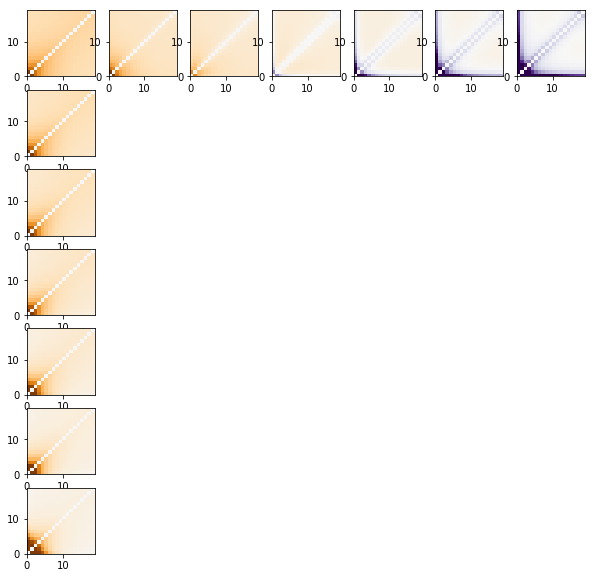

In [197]:
v = 0.02
fig = plt.figure(figsize=(10,10))
nrows = len(gs) + 1
ncols = len(alphas) + 1
ax = fig.add_subplot(nrows, ncols, 1)
ax.pcolor(wpmi_kingman, cmap='PuOr', vmin=-v, vmax=v)

for i, wpmi in enumerate(wpmi_exp):
    ax = fig.add_subplot(nrows, ncols, 1+(ncols*(i+1)))
    ax.pcolor(wpmi, cmap='PuOr', vmin=-v, vmax=v)

for i, wpmi in enumerate(wpmi_beta[::-1]):
    ax = fig.add_subplot(nrows, ncols,2+i)
    ax.pcolor(wpmi, cmap='PuOr', vmin=-v, vmax=v)


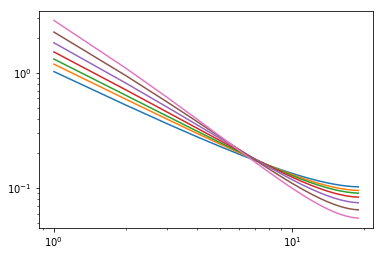

In [113]:
v = 0.02
mac = np.arange(1, n//2+1)
plt.loglog(mac, eta_kingman)
for i, (eta, _) in enumerate(stats_exp):
    plt.loglog(mac, eta)

In [120]:
print("King\t{}".format(lohi_cov(eta_kingman, eta2_kingman)))
for i, g in enumerate(gs):
    print("g={}\t{}".format(g, lohi_cov(*stats_exp[i])))
for i, a in enumerate(alphas):
    print("a={}\t{}".format(a, lohi_cov(*stats_beta[i])))

#for a in alphas:
#    print("a={}\t{}".format(a, sd_pmi(alpha=a)))

King	-0.02564102564102566
g=0.25	-0.02012306511327222
g=0.5	-0.017004901210937562
g=1.0	-0.013301272412572729
g=2.0	-0.01273487544998031
g=4.0	-0.009588165211666944
g=8.0	-0.014369497715857604
a=1.25	0.04662015704478972
a=1.35	0.028125281168155603
a=1.45	0.013265511766807458
a=1.55	0.0014800500394676064
a=1.65	-0.007730084766743639
a=1.75	-0.014808554423553222


In [127]:
print("King\t{}".format(tajimasD(n, eta_kingman)))
for i, g in enumerate(gs):
    print("g={}\t{}".format(g, tajimasD(n, stats_exp[i][0])))
for i, a in enumerate(alphas):
    print("a={}\t{}".format(a, tajimasD(n, stats_beta[i][0])))

#for a in alphas:
#    print("a={}\t{}".format(a, sd_pmi(alpha=a)))

King	0.0
g=0.25	-0.057482644376623204
g=0.5	-0.1004553029047397
g=1.0	-0.16685055494845824
g=2.0	-0.26260872826054316
g=4.0	-0.3914941284870417
g=8.0	-0.5534728689950665
a=1.25	-0.6475675030953278
a=1.35	-0.5268970130219552
a=1.45	-0.41869812512438265
a=1.55	-0.32187386676378993
a=1.65	-0.23536996590351844
a=1.75	-0.1581858489143021


In [227]:
taus = [0.25,.5,1,2]
fs = [0.5]
stats_2ep = [stats(n, "two-epoch", tau=tau, f=f) for f in fs for tau in taus]

../src/zivkovic.py:17: RuntimeWarning: invalid value encountered in log
  alpha[np.isnan(alpha)] = 0
../src/zivkovic.py:17: RuntimeWarning: divide by zero encountered in log
  alpha[np.isnan(alpha)] = 0
../src/zivkovic.py:73: RuntimeWarning: divide by zero encountered in true_divide
  
../src/zivkovic.py:73: RuntimeWarning: invalid value encountered in true_divide
  
../src/zivkovic.py:54: RuntimeWarning: divide by zero encountered in true_divide
  def marginal_leaf_prob(n):
../src/zivkovic.py:135: RuntimeWarning: divide by zero encountered in true_divide
  j_vec = r[:,None]
../src/zivkovic.py:135: RuntimeWarning: invalid value encountered in true_divide
  j_vec = r[:,None]
../src/zivkovic.py:64: RuntimeWarning: divide by zero encountered in true_divide
  
../src/zivkovic.py:34: RuntimeWarning: invalid value encountered in add
  
../src/zivkovic.py:47: RuntimeWarning: invalid value encountered in greater
  F = f(scaled_x[:,None], scaled_x[None,:])
../src/zivkovic.py:34: RuntimeWarning:

In [225]:
print(fs)

[0.5]


[ 1.53197201  0.72220282  0.45805137  0.32979704  0.25555326  0.2080659
  0.17568605  0.1526141   0.13564829  0.1228845   0.11312563  0.10558649
  0.09973528  0.09520327  0.09173096  0.08913485  0.08728642  0.08609867
  0.0855177 ]
[ 0.          0.7779585   0.42258214  0.26623872  0.18668964  0.14348688
  0.11953034  0.1064549   0.09975891  0.09685602  0.09619045  0.09679567
  0.09805785  0.09958161  0.10111046  0.10247804  0.10357751  0.10434218
  0.10473337]
[ 1.39569775  0.68172848  0.44530007  0.32823685  0.25891312  0.21345994
  0.18165289  0.15838451  0.14082207  0.12727085  0.11665759  0.1082724
  0.10162998  0.09639044  0.0923122   0.08922275  0.08700016  0.08556128
  0.08485429]
[ 0.          0.93156607  0.60932821  0.44970123  0.35513032  0.29310039
  0.24967901  0.21790432  0.19391432  0.17539829  0.16089279  0.14942981
  0.14034747  0.13318221  0.12760437  0.12337852  0.1203382   0.11836985
  0.11740269]
[ 1.22450065  0.61211963  0.40866395  0.3074715   0.24721722  0.207464

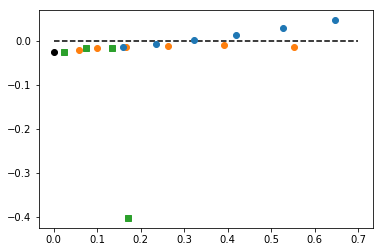

In [228]:
cutoff = 1
plt.plot(-tajimasD(n, eta_kingman), lohi_cov(eta_kingman, eta2_kingman, cutoff=cutoff), 'o', c='k')
for i, g in enumerate(gs):
    plt.plot(-tajimasD(n, stats_exp[i][0]), lohi_cov(*stats_exp[i], cutoff=cutoff), 'o', c='C1')
for i, a in enumerate(alphas):
    plt.plot(-tajimasD(n, stats_beta[i][0]), lohi_cov(*stats_beta[i], cutoff=cutoff), 'o', c='C0')
for s in stats_2ep:
    print(s[0])
    print(s[1][0])
    plt.plot(-tajimasD(n, s[0]), lohi_cov(*s, cutoff=cutoff), 's', c='C2')

plt.hlines(0, 0, 0.7, linestyle='dashed')
#for a in alphas:
#    print("a={}\t{}".format(a, sd_pmi(alpha=a)))

In [124]:
tajimasD(n, eta_kingman)

1.0


0.0